In [1]:
!pip install timm einops opencv-python tqdm

In [2]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

data_dir = "/kaggle/input/hmdb51/HMDB51"

categories = ['brush_hair', 'cartwheel', 'catch', 'chew', 'clap', 'climb', 'climb_stairs', 'dive', 
              'draw_sword', 'dribble', 'drink', 'eat', 'fall_floor', 'fencing', 'flic_flac', 'golf', 
              'handstand', 'hit', 'hug', 'jump', 'kick', 'kick_ball', 'kiss', 'laugh', 'pick', 'pour', 
              'pullup', 'punch', 'push', 'pushup', 'ride_bike', 'ride_horse', 'run', 'shake_hands', 
              'shoot_ball', 'shoot_bow', 'shoot_gun', 'sit', 'situp', 'smile', 'smoke', 'somersault', 
              'stand', 'swing_baseball', 'sword', 'sword_exercise', 'talk', 'throw', 'turn', 'walk', 'wave']

category_to_label = {category: idx for idx, category in enumerate(categories)}

In [3]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(10),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

In [4]:
class HMDB51FrameDataset(Dataset):
    def __init__(self, data_dir, categories, transform=None, frames_per_clip=16):
        self.data_dir = data_dir
        self.categories = categories
        self.transform = transform
        self.frames_per_clip = frames_per_clip
        self.data = []
        self.labels = []
        self._load_data()

    def _load_data(self):
        for category in self.categories:
            category_path = os.path.join(self.data_dir, category)
            if not os.path.exists(category_path):
                continue

            for subdir in os.listdir(category_path):
                subdir_path = os.path.join(category_path, subdir)
                if not os.path.isdir(subdir_path):
                    continue

                frame_files = sorted(os.listdir(subdir_path), key=lambda x: int(x.split('.')[0]))
                frame_paths = [os.path.join(subdir_path, frame) for frame in frame_files if frame.endswith(('.jpg', '.png'))]

                if len(frame_paths) == 0:
                    continue

                selected_frames = self._sample_frames(frame_paths)
                self.data.append(selected_frames)
                self.labels.append(category_to_label[category])

    def _sample_frames(self, frame_paths):
        num_frames = len(frame_paths)
        if num_frames >= self.frames_per_clip:
            indices = np.linspace(0, num_frames - 1, self.frames_per_clip, dtype=int)
        else:
            indices = np.arange(num_frames).tolist()
            while len(indices) < self.frames_per_clip:
                indices.append(indices[-1])

        selected_frames = []
        for idx in indices:
            img = cv2.imread(frame_paths[idx], cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (224, 224))
            img = np.expand_dims(img, axis=0)
            selected_frames.append(img)

        return np.array(selected_frames)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_clip = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            video_clip = np.array([self.transform(frame.squeeze(0)) for frame in video_clip])

        return torch.tensor(video_clip, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [5]:
dataset = HMDB51FrameDataset(data_dir, categories, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [6]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

print(f"Dataset Loaded: {len(dataset)} samples")

Dataset Loaded: 6766 samples


In [61]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast  
from torch.optim.lr_scheduler import ReduceLROnPlateau
from einops import rearrange
from timm.models.vision_transformer import Block

class TimeSformer2(nn.Module):
    def __init__(self, num_classes=51, img_size=224, patch_size=16, num_frames=8, embed_dim=768, num_layers=6):
        super().__init__()
        self.num_patches_per_frame = (img_size // patch_size) ** 2  
        self.total_patches = self.num_patches_per_frame * 16   

        self.patch_embedding = nn.Linear(patch_size * patch_size * 1, embed_dim)
        self.position_embedding = nn.Parameter(torch.zeros(1, self.total_patches, embed_dim)) 

        self.blocks = nn.ModuleList([Block(embed_dim, 12) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        b, t, c, h, w = x.shape
        if t != 16:
            raise ValueError(f"Expected 16 frames, but got {t}") 
 

        x = rearrange(x, 'b t c (h p1) (w p2) -> b (t h w) (p1 p2 c)', p1=16, p2=16)
        x = self.patch_embedding(x)  
        x = x + self.position_embedding  

        for block in self.blocks:
            x = block(x)

        x = self.norm(x.mean(dim=1))  
        return self.head(x)

In [57]:
def train_model(model, train_loader, val_loader, model_name):
    torch.cuda.empty_cache()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    scaler = torch.amp.GradScaler()
    
    num_epochs2 = 10  
    history = {
        "epochs2": [],  
        "train_loss2": [], 
        "train_acc2": [], 
        "val_loss2": [], 
        "val_acc2": []
    }

    for epoch in range(num_epochs2):
        start_time = time.time()
        model.train()
        total_loss, correct_train, total_train = 0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs2}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            with torch.amp.autocast("cuda"): 
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        model.eval()
        total_val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                with torch.amp.autocast("cuda"): 
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                correct_val += (outputs.argmax(1) == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        scheduler.step(avg_val_loss)

        history["epochs2"].append(epoch + 1)
        history["train_loss2"].append(avg_train_loss)
        history["train_acc2"].append(train_accuracy)
        history["val_loss2"].append(avg_val_loss)
        history["val_acc2"].append(val_accuracy)
        
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs2}: "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | "
              f"Time: {epoch_time:.2f}s")

    torch.save({'model_state_dict': model.state_dict(), 'history': history}, f"{model_name}.pth")
    print(f"Model and training history saved to {model_name}.pth")

In [62]:
timeformer_model= TimeSformer2()

In [63]:
train_model(timeformer_model, train_loader, val_loader, "TimeSformer_HMDB51")

Epoch 1/10: 100%|██████████| 1353/1353 [10:39<00:00,  2.12it/s]


Epoch 1/10: Train Loss: 3.8452 | Train Acc: 0.0695 | Val Loss: 3.6667 | Val Acc: 0.0886 | Time: 682.61s


Epoch 2/10: 100%|██████████| 1353/1353 [10:52<00:00,  2.07it/s]


Epoch 2/10: Train Loss: 3.7075 | Train Acc: 0.0759 | Val Loss: 3.6648 | Val Acc: 0.0628 | Time: 696.12s


Epoch 3/10: 100%|██████████| 1353/1353 [10:54<00:00,  2.07it/s]


Epoch 3/10: Train Loss: 3.5989 | Train Acc: 0.0861 | Val Loss: 3.5945 | Val Acc: 0.0879 | Time: 697.96s


Epoch 4/10: 100%|██████████| 1353/1353 [10:53<00:00,  2.07it/s]


Epoch 4/10: Train Loss: 3.5211 | Train Acc: 0.0944 | Val Loss: 3.5821 | Val Acc: 0.0960 | Time: 697.20s


Epoch 5/10: 100%|██████████| 1353/1353 [10:53<00:00,  2.07it/s]


Epoch 5/10: Train Loss: 3.4745 | Train Acc: 0.1016 | Val Loss: 3.4203 | Val Acc: 0.1248 | Time: 697.81s


Epoch 6/10: 100%|██████████| 1353/1353 [10:54<00:00,  2.07it/s]


Epoch 6/10: Train Loss: 3.4245 | Train Acc: 0.1094 | Val Loss: 3.4688 | Val Acc: 0.1115 | Time: 698.44s


Epoch 7/10: 100%|██████████| 1353/1353 [10:55<00:00,  2.07it/s]


Epoch 7/10: Train Loss: 3.3738 | Train Acc: 0.1144 | Val Loss: 3.4586 | Val Acc: 0.0982 | Time: 698.95s


Epoch 8/10: 100%|██████████| 1353/1353 [10:54<00:00,  2.07it/s]


Epoch 8/10: Train Loss: 3.3408 | Train Acc: 0.1282 | Val Loss: 3.3635 | Val Acc: 0.1300 | Time: 698.58s


Epoch 9/10: 100%|██████████| 1353/1353 [10:55<00:00,  2.06it/s]


Epoch 9/10: Train Loss: 3.2965 | Train Acc: 0.1297 | Val Loss: 3.3051 | Val Acc: 0.1352 | Time: 699.45s


Epoch 10/10: 100%|██████████| 1353/1353 [10:55<00:00,  2.06it/s]


Epoch 10/10: Train Loss: 3.2497 | Train Acc: 0.1506 | Val Loss: 3.2984 | Val Acc: 0.1388 | Time: 699.97s
Model and training history saved to TimeSformer_HMDB51.pth


In [66]:
his1 = torch.load("TimeSformer_HMDB51.pth", weights_only=False)  
his_data = his1["history"]  

epochs2 = his_data["epochs2"]
train_loss2 = his_data["train_loss2"]
train_acc2 = his_data["train_acc2"]
val_loss2 = his_data["val_loss2"]
val_acc2 = his_data["val_acc2"]

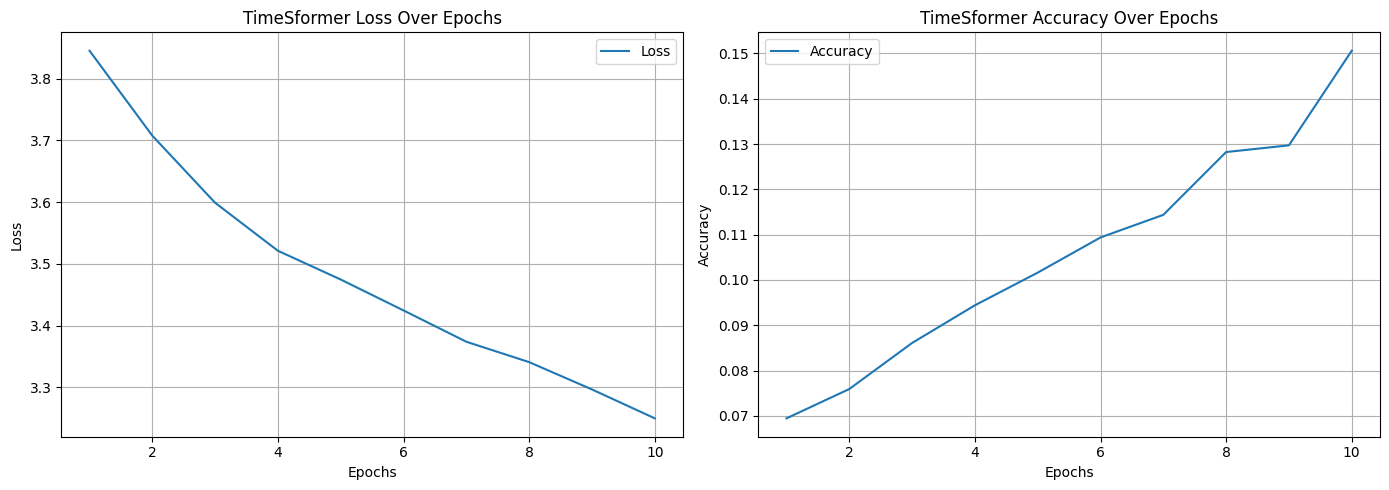

In [67]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(epochs2, train_loss2, label="Loss", linestyle='-')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("TimeSformer Loss Over Epochs")
ax[0].legend()
ax[0].grid()

ax[1].plot(epochs2, train_acc2, label="Accuracy", linestyle='-')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("TimeSformer Accuracy Over Epochs")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()